In [3]:
import ipcmagic
import ipyparallel as ipp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [4]:
%ipcluster start -n 12 --mpi

  0%|          | 0/12 [00:00<?, ?engine/s]

In [5]:
rc = ipp.Client()
rc.ids
dv = rc[:]
dv.activate()
dv.block = True
print("Running IPython Parallel on {0} MPI engines".format(len(rc.ids)))
%px from mpi4py import MPI
%px mpi_rank = MPI.COMM_WORLD.Get_rank()
dv_master = dv.pull("mpi_rank").index(0)

Running IPython Parallel on 12 MPI engines


In [6]:
%%px
import os
import timeit

import numpy as np
from mpi4py import MPI
import stencil_mpi_3d

comm = MPI.COMM_WORLD
num_ranks = comm.Get_size()
rank = comm.Get_rank()

In [7]:
%%px
from partitioner import Partitioner

In [8]:
%%px
nx=128
ny=128
nz=64
num_iter=10
num_halo=2
num_zhalo=2

In [9]:
%%px
run stencil_mpi_3d.py --nx 128 --ny 128 --nz 64 --num_iter 10 --plot_result True

[stdout:2] Elapsed time for work = 0.03527665138244629 s


[stdout:3] Elapsed time for work = 0.035272836685180664 s


[stdout:4] Elapsed time for work = 0.03527116775512695 s


[stdout:1] Elapsed time for work = 0.03527522087097168 s


[stdout:11] Elapsed time for work = 0.03528404235839844 s


[stdout:9] Elapsed time for work = 0.035292863845825195 s


[stdout:6] Elapsed time for work = 0.03527545928955078 s


[stdout:5] Elapsed time for work = 0.035283803939819336 s


[stdout:8] Elapsed time for work = 0.035280466079711914 s


[stdout:0] Elapsed time for work = 0.03528642654418945 s


[stdout:7] Elapsed time for work = 0.03527045249938965 s


[stdout:10] Elapsed time for work = 0.03528952598571777 s


In [10]:
%%px
p = Partitioner(comm, [nz+2*num_zhalo, ny, nx], num_halo)

In [11]:
%%px
f = -1*np.ones(p.shape())
f[:, num_halo:-num_halo, num_halo:-num_halo] = p.rank()
global_f = p.gather(f, root=0)


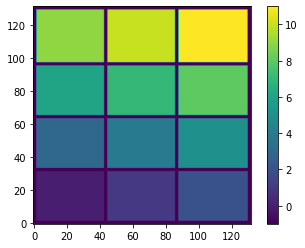

In [12]:
global_f = dv.pull("global_f", targets=dv_master)
plt.imshow(global_f[0, :, :], origin="lower", interpolation=None)
plt.colorbar()

In [13]:
%%px
update_halo(f, num_halo, num_zhalo, p=p)
global_f_2 = p.gather(f, root=0)


(132,)

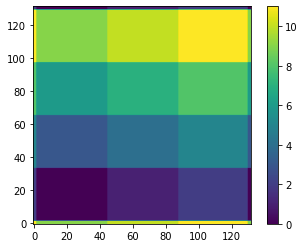

In [14]:
global_f_2 = dv.pull("global_f_2", targets=dv_master)
plt.imshow(global_f_2[0, :, :], origin="lower", interpolation=None)
plt.colorbar()
np.shape(global_f[5,5,:])

In [34]:
%%px
print(f[10,10,10])

[stdout:2] 6.0


[stdout:1] 5.0


[stdout:5] 10.0


[stdout:6] 9.0


[stdout:7] 8.0


[stdout:0] 4.0


[stdout:8] 2.0


[stdout:9] 1.0


[stdout:10] 0.0


[stdout:3] 7.0


[stdout:4] 11.0


[stdout:11] 3.0


In [15]:
%%px
np.save('f'+str(p.rank()), f[10,:,:])

In [42]:
dat=np.load('f' + str(6) + '.npy')
dat[10,10]

6.0

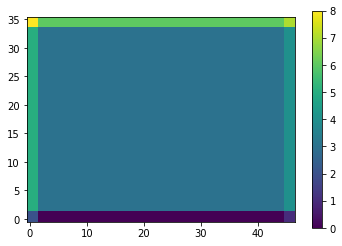

In [45]:
plt.imshow(np.load('f' + str(3) + '.npy'), origin="lower", extent=None)
plt.colorbar()

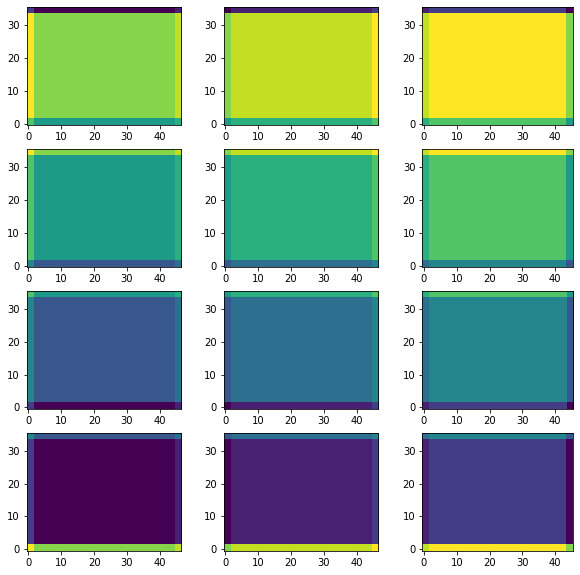

In [60]:
rows=4
cols=3
fig,ax=plt.subplots(rows,cols,figsize=(10, 10))
for i in range(rows*cols):
    data=np.load('f' + str(i) + '.npy')
    ax[(-i-1)//cols,i%cols].imshow(data, origin="lower",cmap='viridis',vmin=0,vmax=11)